<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/main/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is dedicated to exploring the training dataset

# Imports

In [28]:
# google drive
from google.colab import drive

# data
import pandas as pd

# math
import numpy as np

# plotting
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

## PEP8 code standard

In [36]:
# PEP 8 
# %%capture 
!pip install pycodestyle 
!pip install --index-url https://test.pypi.org/simple/ nbpep8 

In [37]:
from nbpep8.nbpep8 import pep8

ModuleNotFoundError: ignored

## Importing custom packages

In [38]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Spaceship-Titanic/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

# pep8(_ih)

In [39]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager
from sklearn_utils import (
    nan_statistics,
    visualize_datasets_distributions
)

# Set up paths

In [40]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Frame the problem

1. Type of task?
	- Supervised learning
	- Classification
	- Batch learning (not online)
2. How company will benefit from task? How model will be used?
    - *To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.*
3. Algorithms?
    - Log regression baseline
    - FFNN
    - Random forest
    - SVM classification
4. Performance measure?
    - Cross entropy loss for binary classification
    - F1 metrics for performance (check the class balance)
5. Domain knowledge?
    - None
6. What the current solution looks like (if any)?
    - No current solution
7. Are there hypotheses to build? (Before looking at the data!)
    - None

# Download the data

In [41]:
manager.train_path

'/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/train.csv'

In [42]:
df_test = pd.read_csv(manager.test_path)

df_train = pd.read_csv(manager.train_path)
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [43]:
train_cols = set(df_train.columns)
test_cols = set(df_test.columns)

assert train_cols - test_cols == {'Transported'}

# Quick look at the data (conclusions are described in journal)

In [44]:
from sklearn_utils import nan_statistics


_ = nan_statistics(df_train)

In [45]:
df_train.info()

In [46]:
df_train.fillna(0).describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.234326,220.009318,448.434027,169.572300,304.588865,298.261820
std,14.912090,660.519050,1595.790627,598.007164,1125.562559,1134.126417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


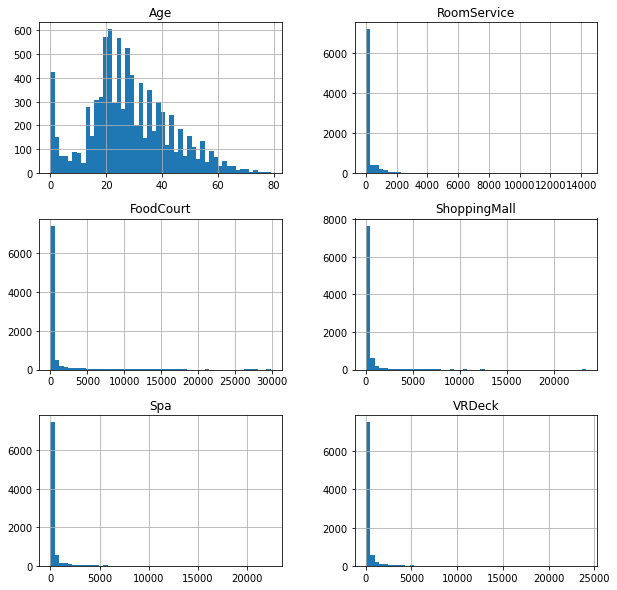

In [47]:
_ = df_train.\
    fillna(0, inplace=False).\
    hist(bins=50, figsize=(10, 10))

## Class balance

As we see below, the training dataset is perfectly balanced

In [48]:
df_train['Transported'].value_counts() / df_train.shape[0]

True     0.503624
False    0.496376
Name: Transported, dtype: float64

## Are train and test features similarly distributed?

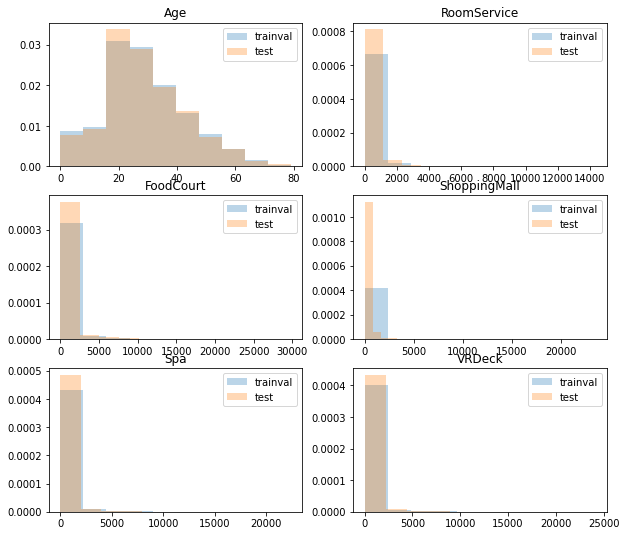

In [49]:
visualize_datasets_distributions(
    {
        'trainval': df_train,
        'test': df_test,
    },
    list(
        df_test.columns[df_test.dtypes == 'float64']
    ),
    grid_width_=2,
    figwidth_=10
)

# Create trainval and test sets

In [50]:
RANDOM_STATE = 42
TEST_PERCENTAGE = 0.1

df_trainval_sample, df_test_sample = \
    train_test_split(
        df_train,
        test_size=TEST_PERCENTAGE,
        random_state=RANDOM_STATE,
        shuffle=True,
        stratify=df_train['Transported']
    )

In [51]:
print(df_trainval_sample['Transported'].value_counts(normalize=True))
print(df_test_sample['Transported'].value_counts(normalize=True))

Visualizing datasets distributions


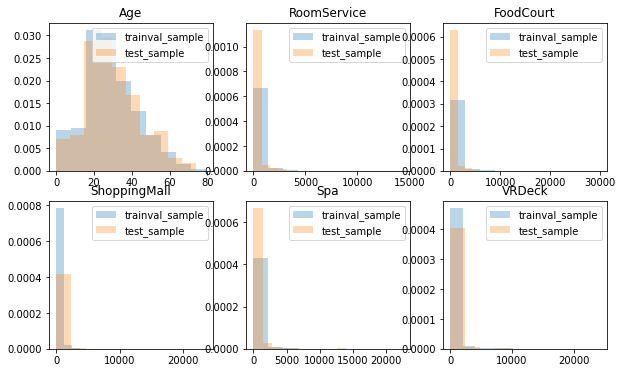

In [ ]:
visualize_datasets_distributions(
    {
        'trainval_sample': df_trainval_sample,
        'test_sample': df_test_sample
    },
    columns_=df_trainval_sample.columns[
        df_trainval_sample.dtypes=='float64'
    ]
)

# Data exploration (with trainval set)

## Sample an exploration dataset

We do not sample a subset out of the trainval dataset, because the size of ~7000 instances is not too large. However, to preserve the original data, we will work with the copy of the dataset

In [52]:
df_exploration = df_trainval_sample.copy()

In [53]:
df_exploration.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

## Passenger Id

In [54]:
df_exploration.PassengerId

3388    3645_02
1013    1083_01
2483    2663_01
4431    4710_01
951     1012_01
         ...   
4406    4678_01
4409    4680_02
4964    5298_01
3049    3294_01
6677    7040_01
Name: PassengerId, Length: 7823, dtype: object

## Home planet

In [55]:
df_exploration.HomePlanet.value_counts()

Earth     4134
Europa    1909
Mars      1596
Name: HomePlanet, dtype: int64

In [56]:
home_planet_table = pd.pivot_table(
    df_exploration,
    values=['Transported'],
    index=['HomePlanet'],
    aggfunc=['sum', 'count']
)

home_planet_table['Transported %'] = \
    home_planet_table['sum']['Transported'] \
    / home_planet_table['count']['Transported']

home_planet_table

,sum,count,Transported %
,Transported,Transported,
HomePlanet,,,
Earth,1751,4134,0.423561
Europa,1252,1909,0.655841
Mars,844,1596,0.528822


## CryoSleep

In [61]:
df_exploration.CryoSleep.isna().sum() / len(df_exploration)

0.02492649878563211

In [59]:
cryo_sleep_table = pd.pivot_table(
    df_exploration,
    values=['Transported'],
    index=['CryoSleep'],
    aggfunc=['sum', 'count']
)

cryo_sleep_table['Transported %'] = \
    cryo_sleep_table['sum']['Transported'] \
    / cryo_sleep_table['count']['Transported']

cryo_sleep_table

,sum,count,Transported %
,Transported,Transported,
CryoSleep,,,
False,1626,4913,0.330959
True,2220,2715,0.817680


## Cabin

In [66]:
print(df_exploration.Cabin.nunique())
df_exploration.Cabin.value_counts()

G/734/S     7
E/13/S      7
C/137/S     7
G/1368/P    7
F/1411/P    7
           ..
G/1465/P    1
F/131/P     1
E/76/S      1
F/915/S     1
G/1150/S    1
Name: Cabin, Length: 5994, dtype: int64

## Destination

In [67]:
df_exploration.Destination.value_counts()

TRAPPIST-1e      5306
55 Cancri e      1640
PSO J318.5-22     718
Name: Destination, dtype: int64

In [57]:
df_exploration.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')